### Imports

In [372]:
import pandas as pd
import json
import os, sys
from tqdm import tqdm
import numpy as np
import polars as pl
from polars import col as c
from pprint import pprint
import matplotlib.pyplot as plt
import re
import shap
import pickle
import git
import seaborn as sns

repo = git.Repo(search_parent_directories=True)

sys.path.append("../")
pl.Config.set_tbl_rows(50)

# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer  # noqa

# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor, CatBoostClassifier
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample

from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    fbeta_score,
    matthews_corrcoef,
    log_loss,
    confusion_matrix,
    precision_recall_curve,
    average_precision_score,
    roc_curve,
    auc,
)

### constants

In [195]:
FILES_DIR = "../data"
MODELS_DIR = "../models"

In [196]:
icd_feature_map = {
    "disease_I48": "atrial_fibrillation",
    "disease_E04": "nontoxic_goiter",
    "disease_E66": "obesity",
    "disease_I67": "other_cerebrovascular_diseases",
    "disease_I49": "other_cardiac_arrhythmias",
    "disease_I63": "cerebral_infarction",
    "disease_K86": "other_pancreas_diseases",
    "disease_N18": "chronic_kidney_disease",
    "disease_I45": "conduction_disorders",
    "disease_I64": "stroke_unspecified",
    "disease_D64": "other_anemias",
    "disease_K29": "gastritis_duodenitis",
    "disease_J42": "chronic_bronchitis",
    "disease_E03": "other_hypothyroidism",
    "disease_I25": "chronic_ischemic_heart_disease",
    "disease_C18": "colon_cancer",
    "disease_C61": "prostate_cancer",
    "disease_N20": "kidney_ureter_stones",
    "disease_B18": "chronic_viral_hepatitis",
    "disease_D50": "iron_deficiency_anemia",
    "disease_U07": "covid19",
    "disease_I44": "atrioventricular_block",
    "disease_H90": "hearing_loss",
    "disease_C34": "lung_cancer",
    "disease_N28": "other_kidney_ureter_diseases",
    "disease_L40": "psoriasis",
    "disease_I70": "atherosclerosis",
    "disease_N40": "prostate_hyperplasia",
    "disease_J45": "asthma",
    "disease_E74": "other_carbohydrate_metabolism_disorders",
    "disease_I47": "paroxysmal_tachycardia",
    "disease_I69": "cerebrovascular_sequelae",
    "disease_I35": "aortic_valve_disorder",
    "disease_E11": "type2_diabetes",
    "gender": "gender",
    "disease_I71": "aortic_aneurysm",
    "disease_M42": "scheuermann_disease",
    "disease_I11": "hypertensive_heart_disease",
    "disease_E10": "type1_diabetes",
    "disease_E06": "thyroiditis",
    "disease_M10": "gout",
    "disease_K26": "duodenal_ulcer",
    "disease_J44": "copd",
    "disease_K80": "gallstones",
    "disease_K25": "gastric_ulcer",
    "disease_I50": "heart_failure",
    "disease_C50": "breast_cancer",
    "disease_I83": "varicose_veins",
    "disease_I34": "mitral_valve_disorder",
    "disease_G93": "other_brain_disorders",
    "full_wards_killip_class": "killip_class",
}

In [197]:
numerical_feature_map = {
    "full_wards_ecg_right_atrium": "right_atrium",
    "full_wards_ecg_left_atrium": "left_atrium",
    "full_wards_ecg_right_ventricle": "right_ventricle",
    "full_wards_ecg_end_diastolic_volume": "end_diastolic_volume",
    "full_wards_ecg_end_systolic_volume": "end_systolic_volume",
    "full_wards_ecg_stroke_volume": "stroke_volume",
    "full_wards_ecg_ventricular_septal": "ventricular_septal",
    "full_wards_ecg_aorta_diameter_valsalva_sinuses": "aorta_diameter_valsalva_sinuses",
    "full_wards_ecg_age": "age",
    "full_wards_ecg_heart_rate": "heart_rate",
    "full_wards_ecg_ascending_aorta": "ascending_aorta",
    "full_wards_ecg_ejection_fraction": "ejection_fraction",
    "bmi": "bmi",
}

### select data

In [198]:
path = "data_for_models"
os.makedirs(os.path.join(FILES_DIR, path), exist_ok=True)
file_name = "labeled_data_filtered.parquet"
file_path = os.path.join(FILES_DIR, path, file_name)
labeled_data = pl.read_parquet(file_path)

with open(
    os.path.join(os.path.join(FILES_DIR, path), "numerical_cols.pickle"), "rb"
) as f:
    numerical_cols = pickle.load(f)

with open(
    os.path.join(os.path.join(FILES_DIR, path), "discrete_cols.pickle"), "rb"
) as f:
    discrete_cols = pickle.load(f)

In [199]:
labeled_data.sample(2)

admission_datetime,gender,patient_id,gospitalisation_type,gospitalisation_delivery,target,final_table1_main_desease_status,final_table1_gospitalization_result,condition_status,full_wards_ecg_right_atrium,full_wards_ecg_left_atrium,full_wards_ecg_right_ventricle,full_wards_ecg_end_diastolic_volume,full_wards_ecg_end_systolic_volume,full_wards_ecg_stroke_volume,full_wards_ecg_ejection_fraction,full_wards_ecg_ventricular_septal,full_wards_ecg_aorta_diameter_valsalva_sinuses,full_wards_ecg_ascending_aorta,full_wards_ecg_age,full_wards_ecg_heart_rate,full_wards_killip_class,main_disease_I21,main_disease_I20,disease_E03,disease_C34,disease_E06,disease_I47,disease_K25,disease_C50,disease_I35,disease_N20,disease_K29,disease_D50,disease_I70,disease_M10,disease_I50,disease_I71,disease_I69,disease_J42,disease_D64,disease_K86,disease_I25,disease_G93,disease_E66,disease_U07,disease_N40,disease_I67,disease_C61,disease_E11,disease_K80,disease_B18,disease_I11,disease_J44,disease_K26,disease_H90,disease_L40,disease_E10,disease_N18,disease_I63,disease_E04,disease_I48,disease_M42,disease_J45,disease_E74,disease_I64,disease_I49,disease_I34,disease_I45,disease_C18,disease_I83,disease_I44,disease_N28,bmi
date,i64,str,i64,i64,i32,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i32,i32,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,f64
2020-02-05,0,"""775CFFC4-57F1-4492-8A48-1EB562…",0,0,-1,2,3,0,4.7,5.1,3.8,142.0,68.0,74.0,45.0,1.1,3.6,0.4,79.0,30.0,null,1,0,false,false,false,false,true,false,false,false,true,false,false,false,true,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,true,false,false,false,false,false,true,false,false,true,false,false,false,false,false,true,false,false,false,false,false,null
2022-11-24,1,"""585B5A10-F896-408E-A915-DE9ABA…",0,0,-1,2,0,0,3.1,3.7,3.1,114.0,51.0,63.0,56.0,1.2,3.5,0.3,65.0,49.0,1,0,1,false,false,false,false,false,false,false,true,false,false,true,false,true,false,false,false,false,false,false,false,false,false,false,true,false,false,false,false,true,false,true,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,24.0


### possible targets

In [200]:
labeled_data["target"].value_counts().sort("count")

target,count
i32,u32
1,473
0,518
-1,6289


In [201]:
labeled_data["main_disease_I21"].value_counts().sort("main_disease_I21")

main_disease_I21,count
i32,u32
null,3
0,3459
1,3818


In [202]:
labeled_data["final_table1_gospitalization_result"].value_counts().sort(
    "final_table1_gospitalization_result"
)

final_table1_gospitalization_result,count
i64,u32
0,6899
1,156
2,8
3,217


### validation metrics

In [ ]:
def classification_metrics(y_true, y_pred_proba, threshold=0.5):
    """
    Print classification metrics in a pandas DataFrame.

    Parameters:
    - y_true: Ground truth binary labels (0 or 1)
    - y_pred_proba: Predicted probabilities for the positive class
    - threshold: Threshold for converting probabilities to class labels (default = 0.5)
    """
    # Convert predicted probabilities to binary labels
    y_pred = (y_pred_proba >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Compute metrics
    metrics = {
        "ROC_AUC": round(roc_auc_score(y_true, y_pred_proba), 3),
        "PR_AUC": round(average_precision_score(y_true, y_pred_proba), 3),
        "Accuracy": round(accuracy_score(y_true, y_pred), 3),
        "Recall": round(recall_score(y_true, y_pred), 3),
        "FPR": round(fp / (fp + tn), 3),
        "Precision": round(precision_score(y_true, y_pred, zero_division=0), 3),
        "F1": round(f1_score(y_true, y_pred), 3),
        "F2": round(fbeta_score(y_true, y_pred, beta=2), 3),
        "MatthewsCorrCoef": round(matthews_corrcoef(y_true, y_pred), 3),
        "LogLoss": round(log_loss(y_true, y_pred_proba), 3),
    }

    # Convert to DataFrame and print
    metrics_df = pl.DataFrame([metrics])

    return metrics_df

## target - gospitalization_result

### split data

In [204]:
target_gospitalization_result = labeled_data.with_columns(
    c("final_table1_gospitalization_result")
    .replace({2: 1, 3: 1})
    .alias("target_gospitalization_result")
)["target_gospitalization_result"].clone()

# print target ratio
(
    target_gospitalization_result.value_counts()
    .with_columns(
        (c("count") / c("count").sum() * 100).round(2).alias("target_ratio, %")
    )
    .sort("target_gospitalization_result")
)

target_gospitalization_result,count,"target_ratio, %"
i64,u32,f64
0,6899,94.77
1,381,5.23


In [205]:
feature_map = icd_feature_map.copy()
feature_map.update(numerical_feature_map)
print("num of features:", len(feature_map.keys()))
features = labeled_data.rename(feature_map).select(feature_map.values())

num of features: 64


In [206]:
X_train, X_test, y_train, y_test = train_test_split(
    features,
    target_gospitalization_result,
    stratify=target_gospitalization_result,
    test_size=0.2,
    random_state=1,
)

In [207]:
labeled_data.null_count()

admission_datetime,gender,patient_id,gospitalisation_type,gospitalisation_delivery,target,final_table1_main_desease_status,final_table1_gospitalization_result,condition_status,full_wards_ecg_right_atrium,full_wards_ecg_left_atrium,full_wards_ecg_right_ventricle,full_wards_ecg_end_diastolic_volume,full_wards_ecg_end_systolic_volume,full_wards_ecg_stroke_volume,full_wards_ecg_ejection_fraction,full_wards_ecg_ventricular_septal,full_wards_ecg_aorta_diameter_valsalva_sinuses,full_wards_ecg_ascending_aorta,full_wards_ecg_age,full_wards_ecg_heart_rate,full_wards_killip_class,main_disease_I21,main_disease_I20,disease_E03,disease_C34,disease_E06,disease_I47,disease_K25,disease_C50,disease_I35,disease_N20,disease_K29,disease_D50,disease_I70,disease_M10,disease_I50,disease_I71,disease_I69,disease_J42,disease_D64,disease_K86,disease_I25,disease_G93,disease_E66,disease_U07,disease_N40,disease_I67,disease_C61,disease_E11,disease_K80,disease_B18,disease_I11,disease_J44,disease_K26,disease_H90,disease_L40,disease_E10,disease_N18,disease_I63,disease_E04,disease_I48,disease_M42,disease_J45,disease_E74,disease_I64,disease_I49,disease_I34,disease_I45,disease_C18,disease_I83,disease_I44,disease_N28,bmi
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,69,0,0,343,347,345,535,549,578,684,1156,551,902,74,392,3600,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3087


In [208]:
X_train_cut, X_eval, y_train_cut, y_eval = train_test_split(
    X_train,
    y_train,
    stratify=y_train,
    test_size=0.2,
    random_state=1,
)  # 0.25 x 0.8 = 0.2

### impute data

In [209]:
def mice_imputation_regression_pl(
    df_train: pl.DataFrame,
    df_val: pl.DataFrame,
    df_test: pl.DataFrame,
    numerical_cols: list,
) -> pl.DataFrame:
    """
    Implements MICE imputation using Polars and pandas.

    Args:
        df_train: Polars DataFrame.
        numerical_cols: List of numerical columns to impute.

    Returns:
        Polars DataFrame with imputed values.
    """
    # Convert Polars DataFrame to pandas DataFrame
    df_train_pd = df_train.clone().to_pandas()
    df_val_pd = df_val.clone().to_pandas()
    df_test_pd = df_test.clone().to_pandas()

    # Initialize IterativeImputer
    imputer = IterativeImputer(max_iter=10, random_state=0)

    # Impute missing values in the pandas DataFrame
    df_train_pd[numerical_cols] = imputer.fit_transform(df_train_pd[numerical_cols])
    df_val_pd[numerical_cols] = imputer.transform(df_val_pd[numerical_cols])
    df_test_pd[numerical_cols] = imputer.transform(df_test_pd[numerical_cols])

    # Convert the imputed pandas DataFrame back to Polars DataFrame
    df_train_pl = pl.from_pandas(df_train_pd)
    df_val_pl = pl.from_pandas(df_val_pd)
    df_test_pl = pl.from_pandas(df_test_pd)

    return df_train_pl, df_val_pl, df_test_pl


X_train_cut, X_eval, X_test = mice_imputation_regression_pl(
    df_train=X_train_cut,
    df_val=X_eval,
    df_test=X_test,
    numerical_cols=list(numerical_feature_map.values()),
)

/Users/konstantinburkin/Documents/hse_projects/parse-records/.venv/lib/python3.13/site-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [210]:
def mice_imputation_classification_pl(
    df_train: pl.DataFrame,
    df_val: pl.DataFrame,
    df_test: pl.DataFrame,
    discrete_cols: list,
) -> pl.DataFrame:
    """
    Implements MICE imputation using Polars and pandas.

    Args:
        df: Polars DataFrame.
        discrete_cols: List of numerical columns to impute.

    Returns:
        Polars DataFrame with imputed values.
    """
    # Convert Polars DataFrame to pandas DataFrame
    df_train_pd = df_train.clone().to_pandas()
    df_val_pd = df_val.clone().to_pandas()
    df_test_pd = df_test.clone().to_pandas()

    # Initialize IterativeImputer
    imputer = IterativeImputer(
        max_iter=10, random_state=0, estimator=LogisticRegression()
    )

    # Impute missing values in the pandas DataFrame
    df_train_pd[discrete_cols] = imputer.fit_transform(df_train_pd[discrete_cols])
    df_val_pd[discrete_cols] = imputer.transform(df_val_pd[discrete_cols])
    df_test_pd[discrete_cols] = imputer.transform(df_test_pd[discrete_cols])

    # Convert the imputed pandas DataFrame back to Polars DataFrame
    df_train_pl = pl.from_pandas(df_train_pd)
    df_val_pl = pl.from_pandas(df_val_pd)
    df_test_pl = pl.from_pandas(df_test_pd)

    return df_train_pl, df_val_pl, df_test_pl


X_train_cut = X_train_cut.with_columns(
    (c(col) * 1.0) for col in list(icd_feature_map.values())
)
X_eval = X_eval.with_columns((c(col) * 1.0) for col in list(icd_feature_map.values()))
X_test = X_test.with_columns((c(col) * 1.0) for col in list(icd_feature_map.values()))

X_train_cut, X_eval, X_test = mice_imputation_classification_pl(
    df_train=X_train_cut,
    df_val=X_eval,
    df_test=X_test,
    discrete_cols=list(icd_feature_map.values()),
)


X_train_cut = X_train_cut.with_columns(
    (c(col).cast(pl.Int64)) for col in list(icd_feature_map.values())
)
X_eval = X_eval.with_columns(
    (c(col).cast(pl.Int64)) for col in list(icd_feature_map.values())
)
X_test = X_test.with_columns(
    (c(col).cast(pl.Int64)) for col in list(icd_feature_map.values())
)

In [211]:
labeled_data.null_count()  # Verify that null counts are reduced

admission_datetime,gender,patient_id,gospitalisation_type,gospitalisation_delivery,target,final_table1_main_desease_status,final_table1_gospitalization_result,condition_status,full_wards_ecg_right_atrium,full_wards_ecg_left_atrium,full_wards_ecg_right_ventricle,full_wards_ecg_end_diastolic_volume,full_wards_ecg_end_systolic_volume,full_wards_ecg_stroke_volume,full_wards_ecg_ejection_fraction,full_wards_ecg_ventricular_septal,full_wards_ecg_aorta_diameter_valsalva_sinuses,full_wards_ecg_ascending_aorta,full_wards_ecg_age,full_wards_ecg_heart_rate,full_wards_killip_class,main_disease_I21,main_disease_I20,disease_E03,disease_C34,disease_E06,disease_I47,disease_K25,disease_C50,disease_I35,disease_N20,disease_K29,disease_D50,disease_I70,disease_M10,disease_I50,disease_I71,disease_I69,disease_J42,disease_D64,disease_K86,disease_I25,disease_G93,disease_E66,disease_U07,disease_N40,disease_I67,disease_C61,disease_E11,disease_K80,disease_B18,disease_I11,disease_J44,disease_K26,disease_H90,disease_L40,disease_E10,disease_N18,disease_I63,disease_E04,disease_I48,disease_M42,disease_J45,disease_E74,disease_I64,disease_I49,disease_I34,disease_I45,disease_C18,disease_I83,disease_I44,disease_N28,bmi
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,69,0,0,343,347,345,535,549,578,684,1156,551,902,74,392,3600,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3087


### base prediction - mean

In [212]:
preds = y_test.shape[0] * [y_train.mean()]
print("base prediction:", preds[0])

base prediction: 0.052369505494505496


In [213]:
# roc_auc_score(y_test, preds)
display(classification_metrics(y_test, np.array(preds)))

ROC_AUC,PR_AUC,Accuracy,Recall,Precision,F1,F2,MatthewsCorrCoef,LogLoss
f64,f64,f64,f64,f64,f64,f64,f64,f64
0.5,0.052,0.948,0.0,0.0,0.0,0.0,0.0,0.205


### test initial catboost model

In [214]:
import optuna
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import roc_auc_score


def objective(trial):
    # Suggest hyperparameters
    params = {
        "iterations": trial.suggest_int("iterations", 200, 1000, step=100),
        "depth": trial.suggest_int("depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 10),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "random_strength": trial.suggest_float("random_strength", 0.5, 5.0),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "random_seed": 2024,
        "eval_metric": "AUC",
        "loss_function": "Logloss",
        "verbose": 0,
        "task_type": "CPU",  # Use "GPU" if available and desired
        "early_stopping_rounds": 50,
        "thread_count": -1,
        "cat_features": list(icd_feature_map.values()),
    }

    # Create CatBoost model
    model = CatBoostClassifier(**params)

    # Fit model with early stopping
    model.fit(
        X=X_train_cut.to_pandas(),
        y=y_train_cut.to_pandas(),
        early_stopping_rounds=50,
        verbose=25,
        eval_set=(
            X_eval.to_pandas(),
            y_eval.to_pandas(),
        ),
    )

    # Predict probabilities
    y_pred_proba = model.predict_proba(X_eval.to_pandas())[:, 1]

    # Calculate ROC AUC
    auc_score = roc_auc_score(y_eval.to_pandas(), y_pred_proba)

    return auc_score


# Run Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

# Results
print("Best hyperparameters:", study.best_params)
print("Best AUC score:", study.best_value)

[I 2025-08-01 12:27:38,521] A new study created in memory with name: no-name-2d89a445-eb40-4562-ba82-081688dab312


0:	test: 0.5336556	best: 0.5336556 (0)	total: 6.76ms	remaining: 4.72s
25:	test: 0.7020076	best: 0.7021709 (24)	total: 128ms	remaining: 3.31s
50:	test: 0.7017849	best: 0.7054526 (35)	total: 247ms	remaining: 3.14s
75:	test: 0.7152827	best: 0.7153867 (72)	total: 378ms	remaining: 3.1s
100:	test: 0.7183120	best: 0.7197078 (89)	total: 497ms	remaining: 2.95s
125:	test: 0.7216679	best: 0.7219648 (124)	total: 618ms	remaining: 2.82s
150:	test: 0.7221579	best: 0.7223212 (145)	total: 732ms	remaining: 2.66s
175:	test: 0.7287954	best: 0.7287954 (175)	total: 848ms	remaining: 2.52s
200:	test: 0.7296715	best: 0.7296715 (200)	total: 966ms	remaining: 2.4s
225:	test: 0.7298349	best: 0.7298497 (212)	total: 1.08s	remaining: 2.26s
250:	test: 0.7320177	best: 0.7320177 (250)	total: 1.19s	remaining: 2.13s
275:	test: 0.7312455	best: 0.7332650 (266)	total: 1.3s	remaining: 2s
300:	test: 0.7254395	best: 0.7332650 (266)	total: 1.42s	remaining: 1.88s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0

[I 2025-08-01 12:27:40,170] Trial 0 finished with value: 0.7332650273224044 and parameters: {'iterations': 700, 'depth': 3, 'learning_rate': 0.05437539092229052, 'l2_leaf_reg': 7.742037912811732, 'border_count': 61, 'random_strength': 2.8487730899135215, 'bagging_temperature': 0.09948102745240006}. Best is trial 0 with value: 0.7332650273224044.


0:	test: 0.5631237	best: 0.5631237 (0)	total: 20.9ms	remaining: 12.5s
25:	test: 0.7239249	best: 0.7306070 (24)	total: 415ms	remaining: 9.16s
50:	test: 0.7231082	best: 0.7306070 (24)	total: 808ms	remaining: 8.7s


[I 2025-08-01 12:27:41,602] Trial 1 finished with value: 0.7306070325492992 and parameters: {'iterations': 600, 'depth': 9, 'learning_rate': 0.108593251955616, 'l2_leaf_reg': 7.24863827076776, 'border_count': 70, 'random_strength': 2.5375906945804094, 'bagging_temperature': 0.30645898459704923}. Best is trial 0 with value: 0.7332650273224044.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7306070325
bestIteration = 24

Shrink model to first 25 iterations.
0:	test: 0.5082338	best: 0.5082338 (0)	total: 8.24ms	remaining: 6.58s
25:	test: 0.7125505	best: 0.7147630 (24)	total: 175ms	remaining: 5.22s
50:	test: 0.7332131	best: 0.7332131 (50)	total: 311ms	remaining: 4.56s
75:	test: 0.7338441	best: 0.7371110 (52)	total: 440ms	remaining: 4.19s
100:	test: 0.7242962	best: 0.7371110 (52)	total: 569ms	remaining: 3.93s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7371109527
bestIteration = 52

Shrink model to first 53 iterations.


[I 2025-08-01 12:27:42,380] Trial 2 finished with value: 0.7371109527203612 and parameters: {'iterations': 800, 'depth': 4, 'learning_rate': 0.19399586764639684, 'l2_leaf_reg': 9.437813068534492, 'border_count': 56, 'random_strength': 3.18180791153583, 'bagging_temperature': 0.15110920816919682}. Best is trial 2 with value: 0.7371109527203612.


0:	test: 0.5870085	best: 0.5870085 (0)	total: 5.08ms	remaining: 2.53s
25:	test: 0.6909450	best: 0.6910192 (24)	total: 119ms	remaining: 2.18s
50:	test: 0.6933506	best: 0.6943158 (44)	total: 230ms	remaining: 2.03s
75:	test: 0.7077245	best: 0.7079918 (72)	total: 346ms	remaining: 1.93s
100:	test: 0.7072345	best: 0.7084224 (91)	total: 464ms	remaining: 1.83s
125:	test: 0.7104865	best: 0.7110953 (107)	total: 581ms	remaining: 1.72s
150:	test: 0.7136642	best: 0.7138721 (149)	total: 697ms	remaining: 1.61s
175:	test: 0.7136939	best: 0.7144660 (172)	total: 811ms	remaining: 1.49s
200:	test: 0.7170795	best: 0.7175249 (199)	total: 924ms	remaining: 1.37s
225:	test: 0.7227518	best: 0.7227518 (225)	total: 1.03s	remaining: 1.26s
250:	test: 0.7224846	best: 0.7237319 (244)	total: 1.15s	remaining: 1.14s
275:	test: 0.7262117	best: 0.7263305 (274)	total: 1.26s	remaining: 1.03s
300:	test: 0.7269690	best: 0.7272066 (291)	total: 1.38s	remaining: 915ms
325:	test: 0.7278154	best: 0.7283203 (318)	total: 1.5s	remain

[I 2025-08-01 12:27:44,801] Trial 3 finished with value: 0.7322701354240911 and parameters: {'iterations': 500, 'depth': 3, 'learning_rate': 0.018391768681529246, 'l2_leaf_reg': 5.81380650684304, 'border_count': 117, 'random_strength': 1.5720565396862223, 'bagging_temperature': 0.6526553704817557}. Best is trial 2 with value: 0.7371109527203612.


450:	test: 0.7313495	best: 0.7322701 (426)	total: 2.12s	remaining: 230ms
475:	test: 0.7318247	best: 0.7322701 (426)	total: 2.23s	remaining: 113ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7322701354
bestIteration = 426

Shrink model to first 427 iterations.
0:	test: 0.5593817	best: 0.5593817 (0)	total: 5.11ms	remaining: 2.55s
25:	test: 0.6965505	best: 0.7020225 (14)	total: 140ms	remaining: 2.55s
50:	test: 0.7019185	best: 0.7049180 (46)	total: 280ms	remaining: 2.47s
75:	test: 0.7104568	best: 0.7139612 (64)	total: 439ms	remaining: 2.45s
100:	test: 0.7179407	best: 0.7179407 (100)	total: 568ms	remaining: 2.24s
125:	test: 0.7195296	best: 0.7222024 (120)	total: 691ms	remaining: 2.05s


[I 2025-08-01 12:27:45,843] Trial 4 finished with value: 0.7222024233784747 and parameters: {'iterations': 500, 'depth': 5, 'learning_rate': 0.06294378502255742, 'l2_leaf_reg': 5.483875530256322, 'border_count': 129, 'random_strength': 1.6708624677005215, 'bagging_temperature': 0.9642543816928497}. Best is trial 2 with value: 0.7371109527203612.


150:	test: 0.7119714	best: 0.7222024 (120)	total: 811ms	remaining: 1.87s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7222024234
bestIteration = 120

Shrink model to first 121 iterations.
0:	test: 0.5608963	best: 0.5608963 (0)	total: 15.3ms	remaining: 10.7s
25:	test: 0.6948800	best: 0.6948800 (25)	total: 395ms	remaining: 10.2s
50:	test: 0.6970034	best: 0.7030173 (48)	total: 877ms	remaining: 11.2s
75:	test: 0.7054526	best: 0.7081700 (65)	total: 1.25s	remaining: 10.3s
100:	test: 0.6986517	best: 0.7081700 (65)	total: 1.74s	remaining: 10.3s


[I 2025-08-01 12:27:47,943] Trial 5 finished with value: 0.7081699928724162 and parameters: {'iterations': 700, 'depth': 9, 'learning_rate': 0.05139829405907095, 'l2_leaf_reg': 1.4892520611647995, 'border_count': 148, 'random_strength': 4.086445336240051, 'bagging_temperature': 0.33790195822992486}. Best is trial 2 with value: 0.7371109527203612.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7081699929
bestIteration = 65

Shrink model to first 66 iterations.
0:	test: 0.5360537	best: 0.5360537 (0)	total: 13.8ms	remaining: 12.4s
25:	test: 0.7087046	best: 0.7099816 (14)	total: 366ms	remaining: 12.3s
50:	test: 0.7277857	best: 0.7303843 (48)	total: 765ms	remaining: 12.7s
75:	test: 0.7242962	best: 0.7303843 (48)	total: 1.09s	remaining: 11.9s


[I 2025-08-01 12:27:49,477] Trial 6 finished with value: 0.7303842955571395 and parameters: {'iterations': 900, 'depth': 9, 'learning_rate': 0.011014319126424197, 'l2_leaf_reg': 1.2747603117199033, 'border_count': 48, 'random_strength': 1.8530424157279293, 'bagging_temperature': 0.4692232767926331}. Best is trial 2 with value: 0.7371109527203612.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7303842956
bestIteration = 48

Shrink model to first 49 iterations.
0:	test: 0.5079517	best: 0.5079517 (0)	total: 3.44ms	remaining: 1.03s
25:	test: 0.7062990	best: 0.7103677 (24)	total: 100ms	remaining: 1.05s
50:	test: 0.7100113	best: 0.7160846 (42)	total: 203ms	remaining: 990ms
75:	test: 0.7168122	best: 0.7181041 (74)	total: 318ms	remaining: 936ms
100:	test: 0.7159361	best: 0.7191880 (90)	total: 430ms	remaining: 846ms
125:	test: 0.7202869	best: 0.7210590 (114)	total: 540ms	remaining: 746ms
150:	test: 0.7216530	best: 0.7225291 (135)	total: 649ms	remaining: 640ms


[I 2025-08-01 12:27:50,511] Trial 7 finished with value: 0.7238655262532667 and parameters: {'iterations': 300, 'depth': 4, 'learning_rate': 0.01691163772158443, 'l2_leaf_reg': 3.029929017453752, 'border_count': 157, 'random_strength': 0.7086278652001186, 'bagging_temperature': 0.8391174572375187}. Best is trial 2 with value: 0.7371109527203612.


175:	test: 0.7230191	best: 0.7238655 (157)	total: 770ms	remaining: 542ms
200:	test: 0.7209402	best: 0.7238655 (157)	total: 883ms	remaining: 435ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7238655263
bestIteration = 157

Shrink model to first 158 iterations.
0:	test: 0.5301660	best: 0.5301660 (0)	total: 4.87ms	remaining: 1.94s
25:	test: 0.7161217	best: 0.7161217 (25)	total: 133ms	remaining: 1.91s


[I 2025-08-01 12:27:51,146] Trial 8 finished with value: 0.7162479211214065 and parameters: {'iterations': 400, 'depth': 6, 'learning_rate': 0.010746853754811575, 'l2_leaf_reg': 6.325559480414591, 'border_count': 64, 'random_strength': 0.6789139520351771, 'bagging_temperature': 0.8007012962435696}. Best is trial 2 with value: 0.7371109527203612.


50:	test: 0.7073087	best: 0.7162479 (29)	total: 354ms	remaining: 2.42s
75:	test: 0.7072939	best: 0.7162479 (29)	total: 501ms	remaining: 2.13s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7162479211
bestIteration = 29

Shrink model to first 30 iterations.
0:	test: 0.5393725	best: 0.5393725 (0)	total: 3.82ms	remaining: 3.82s
25:	test: 0.7160920	best: 0.7171463 (24)	total: 97.6ms	remaining: 3.66s
50:	test: 0.7303249	best: 0.7328196 (47)	total: 200ms	remaining: 3.73s


[I 2025-08-01 12:27:51,662] Trial 9 finished with value: 0.732819553338085 and parameters: {'iterations': 1000, 'depth': 4, 'learning_rate': 0.0499920955932851, 'l2_leaf_reg': 5.4473040160400075, 'border_count': 134, 'random_strength': 1.3265413268245718, 'bagging_temperature': 0.11811108800678227}. Best is trial 2 with value: 0.7371109527203612.


75:	test: 0.7261077	best: 0.7328196 (47)	total: 311ms	remaining: 3.78s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7328195533
bestIteration = 47

Shrink model to first 48 iterations.
Best hyperparameters: {'iterations': 800, 'depth': 4, 'learning_rate': 0.19399586764639684, 'l2_leaf_reg': 9.437813068534492, 'border_count': 56, 'random_strength': 3.18180791153583, 'bagging_temperature': 0.15110920816919682}
Best AUC score: 0.7371109527203612


In [215]:
model = CatBoostClassifier(
    random_seed=2024,
    cat_features=list(icd_feature_map.values()),
    eval_metric="AUC",
    depth=3,
    iterations=250,
    learning_rate=0.06,
)

model.fit(
    X=X_train_cut.to_pandas(),
    y=y_train_cut.to_pandas(),
    early_stopping_rounds=50,
    verbose=25,
    eval_set=(
        X_eval.to_pandas(),
        y_eval.to_pandas(),
    ),
)

display(classification_metrics(y_test, model.predict_proba(X_test.to_pandas())[:, 1]))

0:	test: 0.5184352	best: 0.5184352 (0)	total: 3.12ms	remaining: 777ms
25:	test: 0.7081551	best: 0.7081551 (25)	total: 92.3ms	remaining: 796ms
50:	test: 0.7151342	best: 0.7176586 (34)	total: 191ms	remaining: 746ms
75:	test: 0.7255286	best: 0.7255286 (75)	total: 303ms	remaining: 694ms
100:	test: 0.7334878	best: 0.7334878 (100)	total: 412ms	remaining: 608ms
125:	test: 0.7329680	best: 0.7375861 (116)	total: 532ms	remaining: 523ms
150:	test: 0.7343045	best: 0.7375861 (116)	total: 636ms	remaining: 417ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.737586125
bestIteration = 116

Shrink model to first 117 iterations.


ROC_AUC,PR_AUC,Accuracy,Recall,Precision,F1,F2,MatthewsCorrCoef,LogLoss
f64,f64,f64,f64,f64,f64,f64,f64,f64
0.774,0.256,0.948,0.013,1.0,0.026,0.016,0.112,0.175


In [216]:
study.best_params

{'iterations': 800,
 'depth': 4,
 'learning_rate': 0.19399586764639684,
 'l2_leaf_reg': 9.437813068534492,
 'border_count': 56,
 'random_strength': 3.18180791153583,
 'bagging_temperature': 0.15110920816919682}

In [217]:
model = CatBoostClassifier(
    random_seed=2024,
    cat_features=list(icd_feature_map.values()),
    eval_metric="AUC",
    **study.best_params,
)

model.fit(
    X=X_train_cut.to_pandas(),
    y=y_train_cut.to_pandas(),
    early_stopping_rounds=50,
    verbose=25,
    eval_set=(
        X_eval.to_pandas(),
        y_eval.to_pandas(),
    ),
)

display(classification_metrics(y_test, model.predict_proba(X_test.to_pandas())[:, 1]))

0:	test: 0.5082338	best: 0.5082338 (0)	total: 4.01ms	remaining: 3.21s
25:	test: 0.7125505	best: 0.7147630 (24)	total: 101ms	remaining: 3.02s
50:	test: 0.7332131	best: 0.7332131 (50)	total: 210ms	remaining: 3.09s
75:	test: 0.7338441	best: 0.7371110 (52)	total: 399ms	remaining: 3.81s
100:	test: 0.7242962	best: 0.7371110 (52)	total: 524ms	remaining: 3.63s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7371109527
bestIteration = 52

Shrink model to first 53 iterations.


ROC_AUC,PR_AUC,Accuracy,Recall,Precision,F1,F2,MatthewsCorrCoef,LogLoss
f64,f64,f64,f64,f64,f64,f64,f64,f64
0.781,0.275,0.948,0.013,0.5,0.026,0.016,0.075,0.172


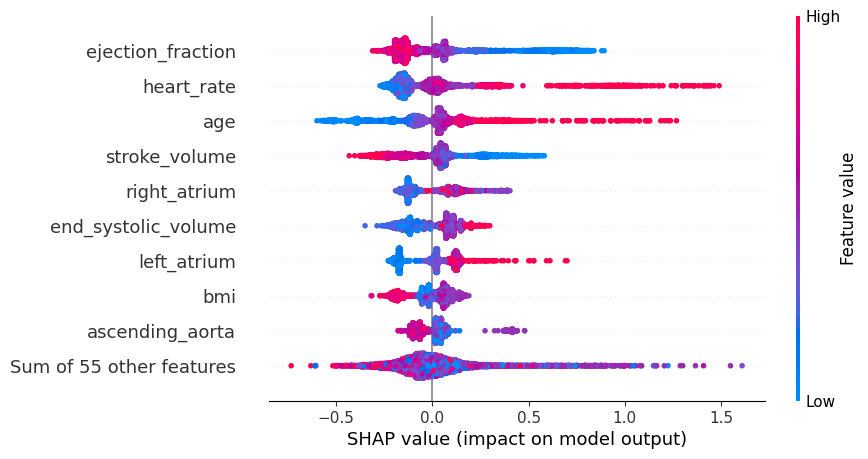

In [218]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_train_cut.to_pandas())
shap.plots.beeswarm(
    shap_values,
    plot_size=(8, 5),
)
plt.show()

In [ ]:
# save model
os.makedirs(os.path.join(MODELS_DIR, repo.head.object.hexsha[:8]), exist_ok=True)
file_name = "catboost.cbm"
file_path = os.path.join(MODELS_DIR, repo.head.object.hexsha[:8], file_name)
# model.save_model(file_path)

### overfit model on small batch

In [319]:
model = CatBoostClassifier(
    random_seed=2024,
    cat_features=list(icd_feature_map.values()),
    eval_metric="AUC",
    **study.best_params,
)

model.fit(
    X=X_eval.to_pandas(),
    y=y_eval.to_pandas(),
    # early_stopping_rounds=50,
    verbose=25,
    # eval_set=(
    #     X_eval.to_pandas(),
    #     y_eval.to_pandas(),
    # ),
)

display(classification_metrics(y_eval, model.predict_proba(X_eval.to_pandas())[:, 1]))

0:	total: 5.48ms	remaining: 4.38s
25:	total: 55.4ms	remaining: 1.65s
50:	total: 104ms	remaining: 1.53s
75:	total: 156ms	remaining: 1.48s
100:	total: 222ms	remaining: 1.54s
125:	total: 293ms	remaining: 1.57s
150:	total: 362ms	remaining: 1.56s
175:	total: 440ms	remaining: 1.56s
200:	total: 502ms	remaining: 1.5s
225:	total: 726ms	remaining: 1.84s
250:	total: 827ms	remaining: 1.81s
275:	total: 894ms	remaining: 1.7s
300:	total: 963ms	remaining: 1.6s
325:	total: 1.02s	remaining: 1.49s
350:	total: 1.08s	remaining: 1.38s
375:	total: 1.14s	remaining: 1.28s
400:	total: 1.2s	remaining: 1.19s
425:	total: 1.26s	remaining: 1.11s
450:	total: 1.32s	remaining: 1.02s
475:	total: 1.37s	remaining: 933ms
500:	total: 1.42s	remaining: 848ms
525:	total: 1.47s	remaining: 767ms
550:	total: 1.52s	remaining: 688ms
575:	total: 1.57s	remaining: 610ms
600:	total: 1.62s	remaining: 535ms
625:	total: 1.66s	remaining: 463ms
650:	total: 1.71s	remaining: 391ms
675:	total: 1.76s	remaining: 323ms
700:	total: 1.82s	remaining

ROC_AUC,PR_AUC,Accuracy,Recall,FPR,Precision,F1,F2,MatthewsCorrCoef,LogLoss
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.016


### model evaluation with LIME and SHAP

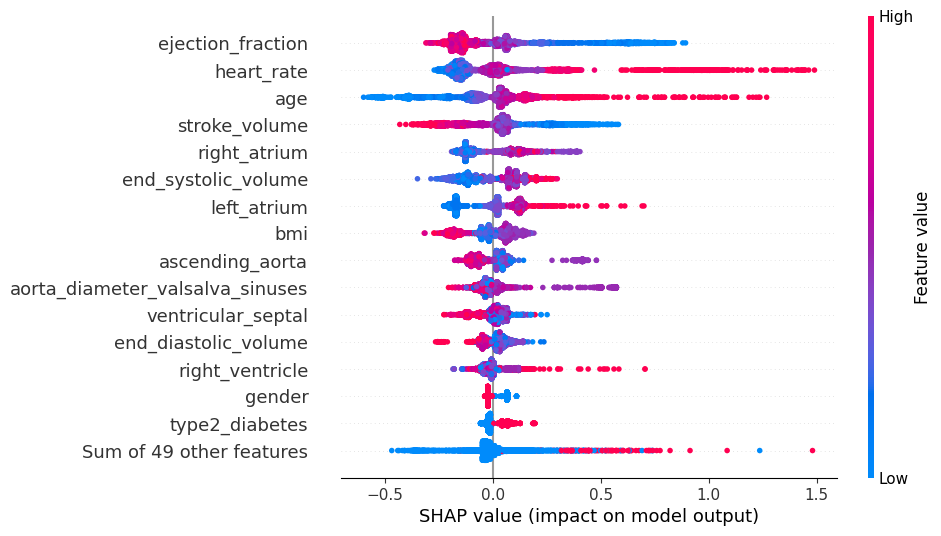

In [337]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_train_cut.to_pandas())
shap.plots.beeswarm(
    shap_values,
    16,
    plot_size=(8, 6),
)
plt.show()

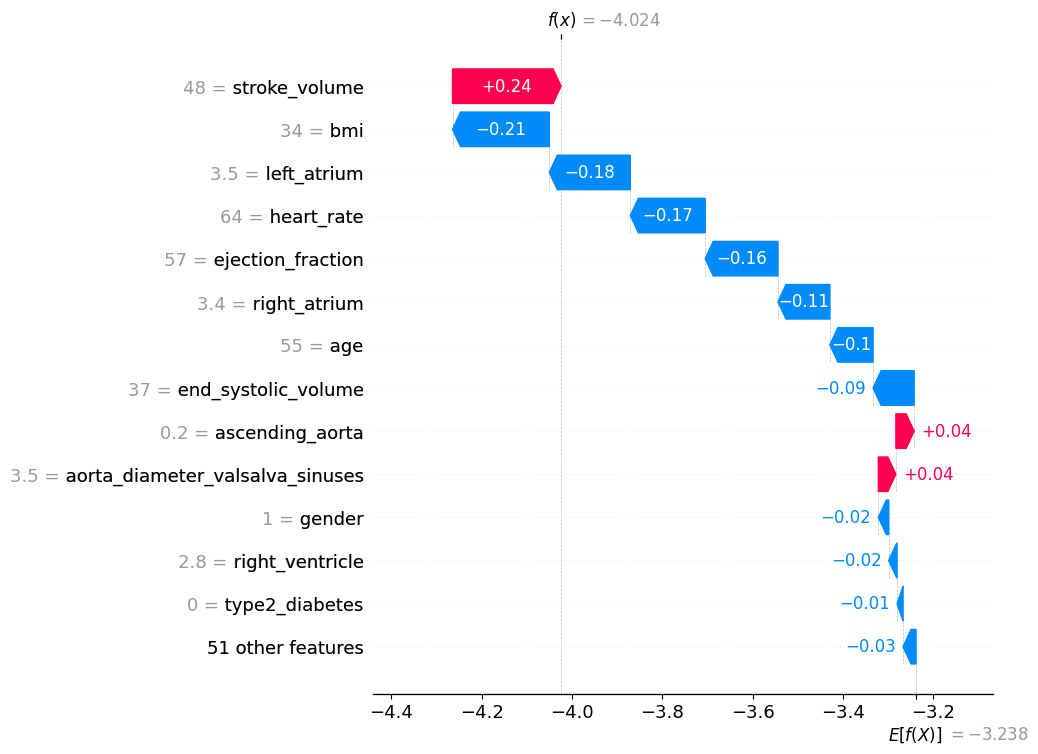

In [ ]:
shap.plots.waterfall(shap_values[0], max_display=14)

/var/folders/yt/5rqq39t16xs0vjb7z99vs0cw0000gn/T/ipykernel_97840/3566976396.py:38: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


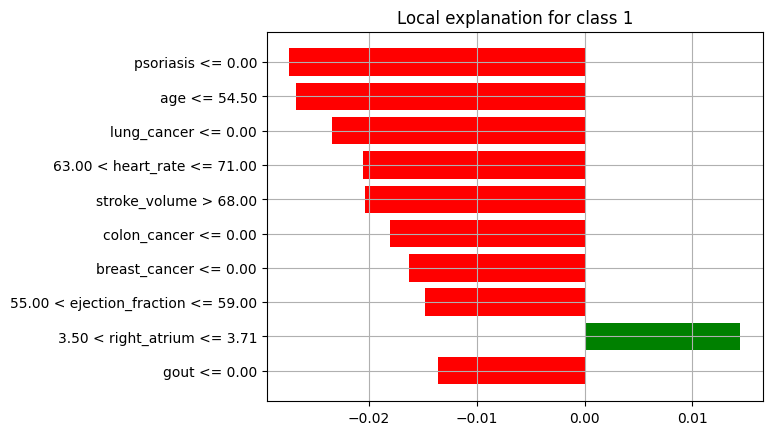

In [359]:
import lime

import lime.lime_tabular

# Initialize the LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_cut.to_pandas().values,
    feature_names=X_train_cut.columns,
    class_names=["0", "1"],
    mode="classification",
)


def lime_predict_fn(x):
    # x is a numpy array, shape (n, features)
    # Convert to DataFrame with correct columns and dtypes
    df = pd.DataFrame(x, columns=X_train_cut.columns)
    # If you have categorical columns, cast them to the correct dtype
    for col in list(icd_feature_map.values()):
        df[col] = df[col].astype(X_train_cut[col].to_pandas().dtype)
    return model.predict_proba(df)


def explain_instance(instance, model, num_features=10):
    explanation = explainer.explain_instance(
        data_row=instance.values,
        predict_fn=lime_predict_fn,
        # num_features=num_features,
    )
    return explanation


# Example usage: Explain the first instance in the test set
instance_to_explain = X_test.to_pandas().iloc[0]
explanation = explain_instance(instance_to_explain, model)
fig = explanation.as_pyplot_figure()
plt.grid()
fig.show()

### random forest

In [360]:
def objective(trial):
    # Define the hyperparameter search space
    n_estimators = trial.suggest_int("n_estimators", 200, 800, step=100)
    max_depth = trial.suggest_int("max_depth", 3, 10)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5)
    #     criterion = trial.suggest_categorical("criterion", ["gini", "entropy"])

    # Train the Random Forest model with the suggested hyperparameters
    rf_model = RandomForestClassifier(
        random_state=2024,
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        #         criterion=criterion,
        n_jobs=-1,
    )
    rf_model.fit(X_train_cut, y_train_cut.to_pandas())

    # Evaluate the model
    y_pred_proba_rf = rf_model.predict_proba(X_eval)[:, 1]
    auc_score_rf = roc_auc_score(y_eval.to_pandas(), y_pred_proba_rf)

    return auc_score_rf


# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

# Print the best hyperparameters and the corresponding AUC score
print("Best hyperparameters:", study.best_params)
print("Best AUC score:", study.best_value)

[I 2025-08-01 13:49:54,069] A new study created in memory with name: no-name-25ab7373-1be3-42d0-956a-246ab6b315e8
[I 2025-08-01 13:49:55,432] Trial 0 finished with value: 0.7434366832976954 and parameters: {'n_estimators': 400, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.7434366832976954.
[I 2025-08-01 13:49:56,780] Trial 1 finished with value: 0.742456640532193 and parameters: {'n_estimators': 500, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.7434366832976954.
[I 2025-08-01 13:49:57,424] Trial 2 finished with value: 0.7469410786410073 and parameters: {'n_estimators': 200, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 5}. Best is trial 2 with value: 0.7469410786410073.
[I 2025-08-01 13:49:58,425] Trial 3 finished with value: 0.7436148728914231 and parameters: {'n_estimators': 400, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 2 with value: 0.7

Best hyperparameters: {'n_estimators': 700, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 4}
Best AUC score: 0.7574542646709431


In [361]:
# Train Random Forest model
rf_model = RandomForestClassifier(
    random_state=2024,
    # n_estimators=500,
    # max_depth=5,
    **study.best_params,
)  # You can adjust hyperparameters as needed
rf_model.fit(
    pl.concat([X_train_cut, X_eval]).to_pandas(),
    pl.concat([y_train_cut, y_eval]).to_pandas(),
)

# Evaluate the model
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]
display(classification_metrics(y_test, y_pred_proba_rf))

ROC_AUC,PR_AUC,Accuracy,Recall,FPR,Precision,F1,F2,MatthewsCorrCoef,LogLoss
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.777,0.265,0.948,0.0,0.0,0.0,0.0,0.0,0.0,0.173


100%|██████████| 1000/1000 [00:44<00:00, 22.40it/s]


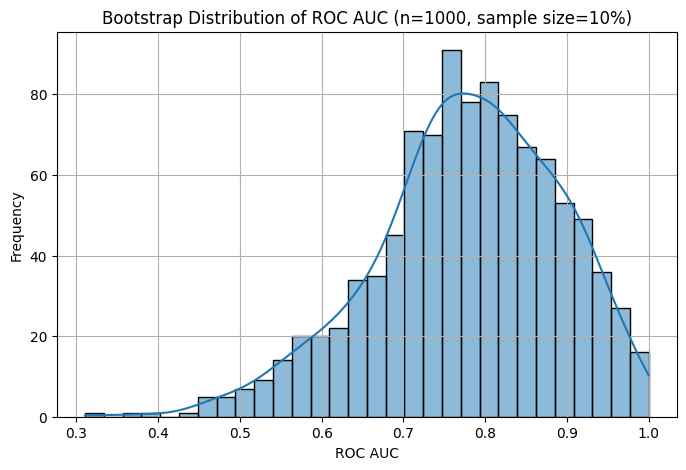

In [383]:
n_bootstrap = 1000
sample_size = int(0.1 * len(y_test))
roc_aucs = []

X_test_pd = X_test.to_pandas()
y_test_np = y_test.to_numpy()

rng = np.random.default_rng(1984)
for _ in tqdm(range(n_bootstrap)):
    idxs = rng.choice(len(y_test), size=sample_size, replace=True)
    y_true_sample = y_test_np[idxs]
    y_pred_sample = rf_model.predict_proba(X_test_pd.iloc[idxs])[:, 1]
    roc_aucs.append(roc_auc_score(y_true_sample, y_pred_sample))

plt.figure(figsize=(8, 5))
sns.histplot(roc_aucs, bins=30, kde=True)
plt.xlabel("ROC AUC")
plt.ylabel("Frequency")
plt.title("Bootstrap Distribution of ROC AUC (n=1000, sample size=10%)")
plt.grid()
plt.show()

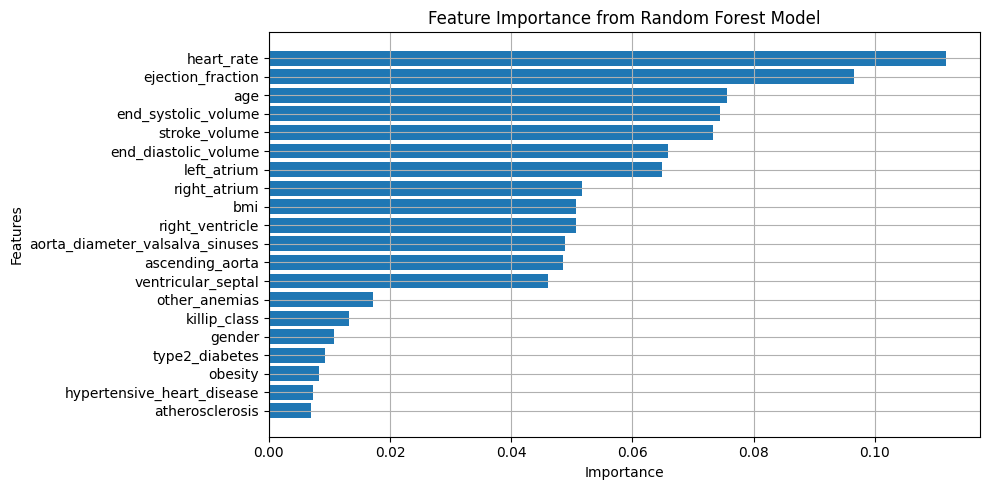

In [ ]:
feature_importance = (
    pd.DataFrame(
        {"feature": X_train.columns, "importance": rf_model.feature_importances_}
    )
    .sort_values("importance", ascending=True)
    .tail(20)
)

plt.figure(figsize=(10, 5))
plt.barh(
    feature_importance["feature"],
    feature_importance["importance"],
)
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Feature Importance from Random Forest Model")
plt.tight_layout()
plt.grid()
plt.show()

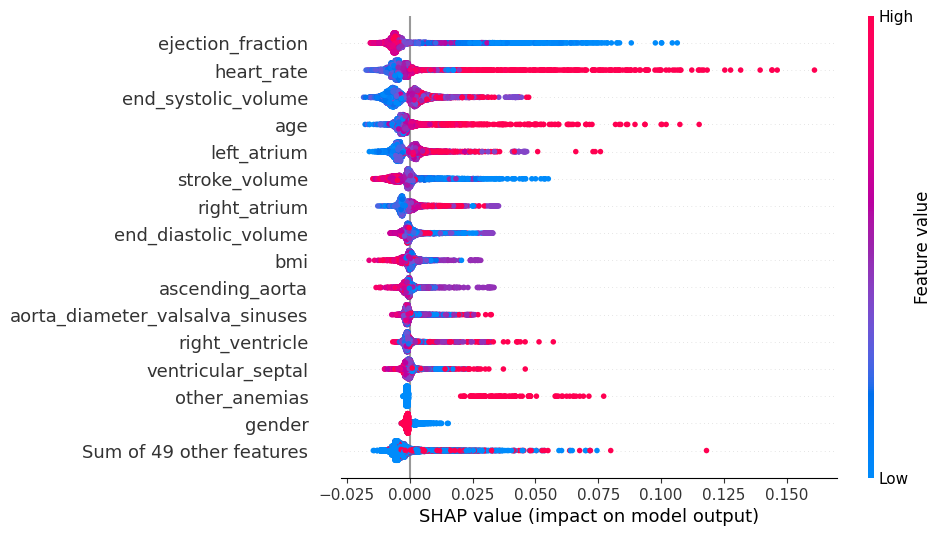

In [ ]:
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer(X_train_cut.to_pandas())
# If shap_values has shape (n_samples, n_features, n_classes), select one class:
shap.plots.beeswarm(
    shap_values[:, :, 1],  # 1 is the class index you want to plot
    max_display=16,
    plot_size=(8, 6),
)
plt.show()

### linear regression

In [264]:
X_train_cut.shape

(4659, 64)

In [263]:
X_train_scaled.shape

(4659, 64)

In [265]:
X_train_scaled_pd.shape

(4659, 13)

In [266]:
X_train_pd.shape

(4659, 51)

In [374]:
# Scale numerical features
scaler = StandardScaler()
X_train_scaled = pl.concat([X_train_cut, X_eval]).with_columns(
    [c(col).cast(pl.Float64) for col in numerical_feature_map.values()]
)
# X_eval_scaled = X_eval.with_columns([c(col).cast(pl.Float64) for col in numerical_feature_map.values()])
X_test_scaled = X_test.with_columns(
    [c(col).cast(pl.Float64) for col in numerical_feature_map.values()]
)

X_train_scaled_pd = pd.DataFrame(
    scaler.fit_transform(
        X_train_scaled.select(numerical_feature_map.values()).to_pandas()
    ),
    columns=numerical_feature_map.values(),
)
# X_eval_scaled_pd = pd.DataFrame(
#     scaler.transform(X_eval_scaled.select(numerical_feature_map.values()).to_pandas()),
#     columns=numerical_feature_map.values(),
# )
X_test_scaled_pd = pd.DataFrame(
    scaler.transform(X_test_scaled.select(numerical_feature_map.values()).to_pandas()),
    columns=numerical_feature_map.values(),
)

X_train_pd = (
    pl.concat([X_train_cut, X_eval])
    .to_pandas()
    .drop(columns=numerical_feature_map.values())
)
# X_eval_pd = X_eval.to_pandas().drop(columns=numerical_feature_map.values())
X_test_pd = X_test.to_pandas().drop(columns=numerical_feature_map.values())

X_train_scaled_final = pd.concat([X_train_scaled_pd, X_train_pd], axis=1)
# X_eval_scaled_final = pd.concat([X_eval_scaled_pd, X_eval_pd], axis=1)
X_test_scaled_final = pd.concat([X_test_scaled_pd, X_test_pd], axis=1)


# Train Logistic Regression model
logistic_model = LogisticRegression(
    random_state=2024,
    solver="liblinear",
    penalty="l1",
)
logistic_model.fit(X_train_scaled_final, pl.concat([y_train_cut, y_eval]).to_pandas())

# Evaluate the model
y_pred_proba = logistic_model.predict_proba(X_test_scaled_final)[:, 1]
auc_score = roc_auc_score(y_test.to_pandas(), y_pred_proba)

print(f"AUC Score: {auc_score:.3f}")

AUC Score: 0.756


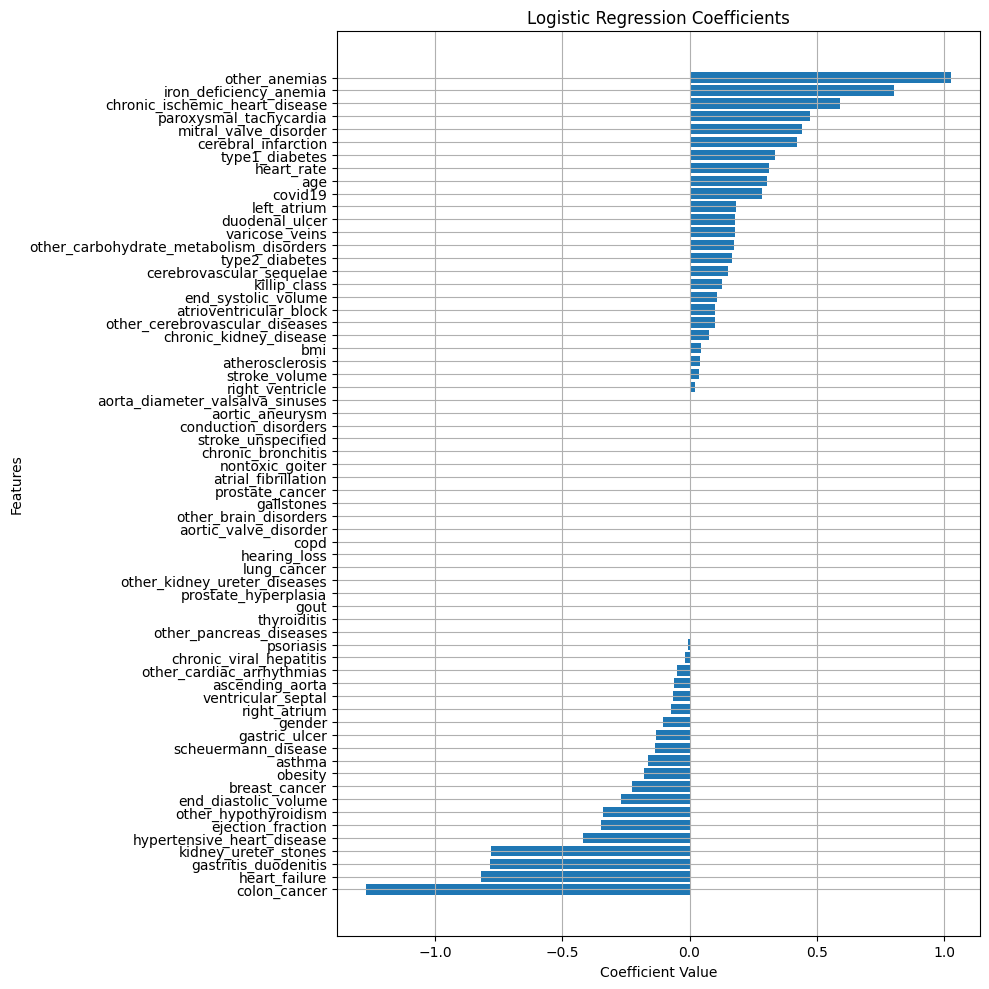

In [375]:
coefficients = pd.DataFrame(
    {
        "feature": X_train_scaled_final.columns,
        "coefficient": logistic_model.coef_[0],
    }
).sort_values("coefficient", ascending=True)

plt.figure(figsize=(10, 10))
plt.barh(
    coefficients["feature"],
    coefficients["coefficient"],
)
plt.xlabel("Coefficient Value")
plt.ylabel("Features")
plt.title("Logistic Regression Coefficients")
plt.tight_layout()
plt.grid()
plt.show()

100%|██████████| 1000/1000 [00:02<00:00, 389.45it/s]


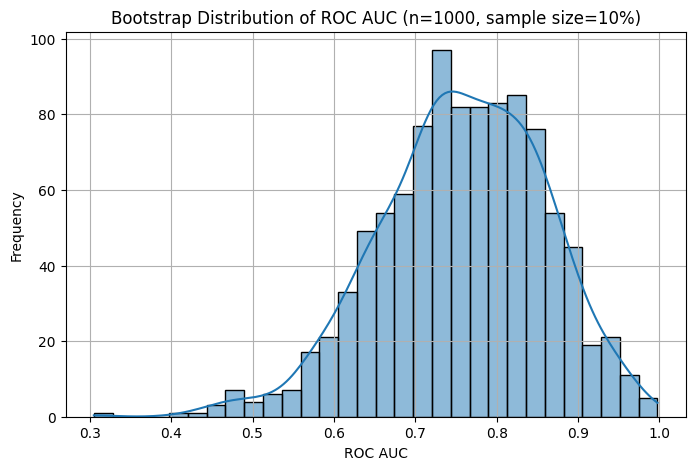

In [ ]:
n_bootstrap = 1000
sample_size = int(0.1 * len(y_test))
roc_aucs = []

# X_test_pd = X_test.to_pandas()
y_test_np = y_test.to_numpy()

X_test_pd = X_test_scaled_final.copy()  # Use scaled and aligned test set

rng = np.random.default_rng(1984)
for _ in tqdm(range(n_bootstrap)):
    idxs = rng.choice(len(y_test), size=sample_size, replace=True)
    y_true_sample = y_test_np[idxs]
    y_pred_sample = logistic_model.predict_proba(X_test_pd.iloc[idxs])[:, 1]
    roc_aucs.append(roc_auc_score(y_true_sample, y_pred_sample))

plt.figure(figsize=(8, 5))
sns.histplot(roc_aucs, bins=30, kde=True)
plt.xlabel("ROC AUC")
plt.ylabel("Frequency")
plt.title("Bootstrap Distribution of ROC AUC (n=1000, sample size=10%)")
plt.grid()
plt.show()

### more metrics of trained model

In [321]:
# load model
file_name = "catboost.cbm"
file_path = os.path.join(MODELS_DIR, repo.head.object.hexsha[:8], file_name)
model = CatBoostClassifier()
model.load_model(file_path)

In [316]:
display(classification_metrics(y_test, model.predict_proba(X_test.to_pandas())[:, 1]))

ROC_AUC,PR_AUC,Accuracy,Recall,FPR,Precision,F1,F2,MatthewsCorrCoef,LogLoss
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.781,0.275,0.948,0.013,0.001,0.5,0.026,0.016,0.075,0.172


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:05<00:00, 187.36it/s]


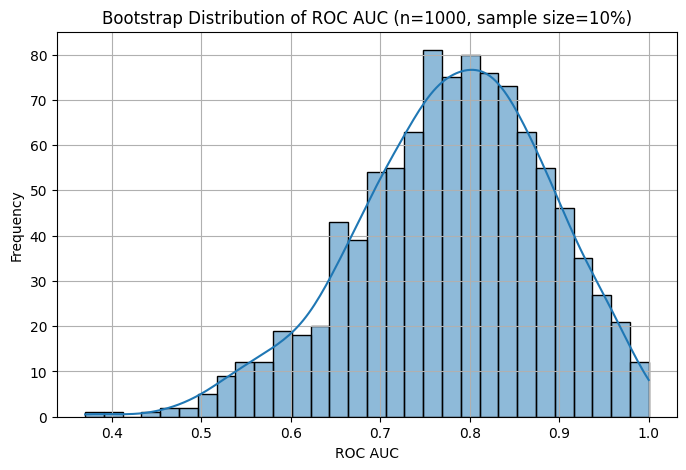

In [384]:
n_bootstrap = 1000
sample_size = int(0.1 * len(y_test))
roc_aucs = []

X_test_pd = X_test.to_pandas()
y_test_np = y_test.to_numpy()

rng = np.random.default_rng(1984)
for _ in tqdm(range(n_bootstrap)):
    idxs = rng.choice(len(y_test), size=sample_size, replace=True)
    y_true_sample = y_test_np[idxs]
    y_pred_sample = model.predict_proba(X_test_pd.iloc[idxs])[:, 1]
    roc_aucs.append(roc_auc_score(y_true_sample, y_pred_sample))

plt.figure(figsize=(8, 5))
sns.histplot(roc_aucs, bins=30, kde=True)
plt.xlabel("ROC AUC")
plt.ylabel("Frequency")
plt.title("Bootstrap Distribution of ROC AUC (n=1000, sample size=10%)")
plt.grid()
plt.show()

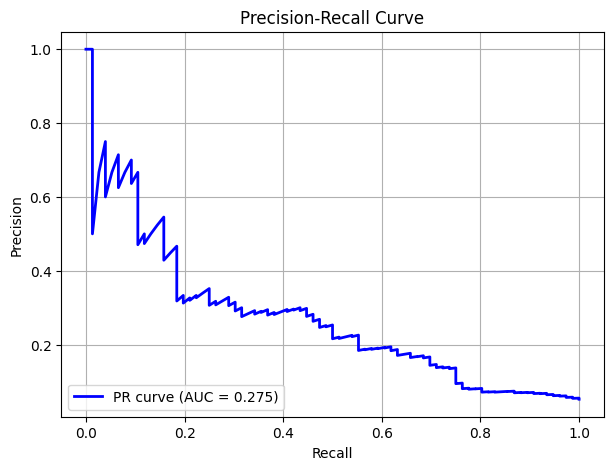

In [285]:
# Get predicted probabilities for the positive class
y_pred_proba = model.predict_proba(X_test.to_pandas())[:, 1]

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test.to_pandas(), y_pred_proba)
pr_auc = average_precision_score(y_test.to_pandas(), y_pred_proba)

plt.figure(figsize=(7, 5))
plt.plot(
    recall,
    precision,
    color="blue",
    lw=2,
    label=f"PR curve (AUC = {pr_auc:.3f})",
)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.grid()
plt.show()

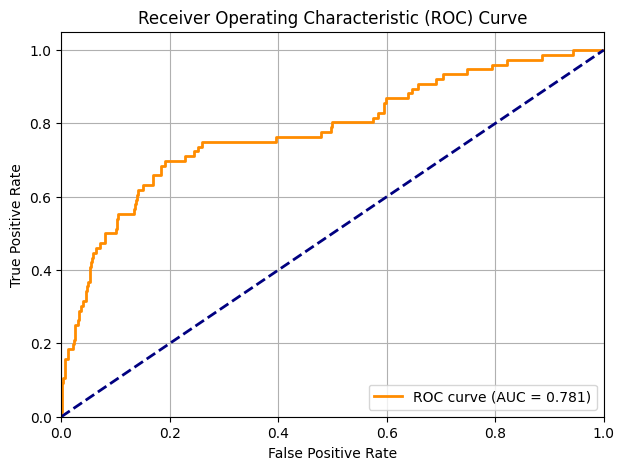

In [309]:
# Get predicted probabilities for the positive class
y_pred_proba = model.predict_proba(X_test.to_pandas())[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test.to_pandas(), y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [317]:
# Find the threshold where TPR (True Positive Rate) is closest to 0.8
target_tpr = 0.8
idx = np.argmin(np.abs(tpr - target_tpr))
threshold = thresholds[idx]
print(f"Threshold for TPR≈{target_tpr}: {threshold:.4f}")
display(
    classification_metrics(
        y_test,
        model.predict_proba(X_test.to_pandas())[:, 1],
        threshold=threshold,
    )
)
target_tpr = 0.9
idx = np.argmin(np.abs(tpr - target_tpr))
threshold = thresholds[idx]
print(f"Threshold for TPR≈{target_tpr}: {threshold:.4f}")
display(
    classification_metrics(
        y_test,
        model.predict_proba(X_test.to_pandas())[:, 1],
        threshold=threshold,
    )
)

Threshold for TPR≈0.8: 0.0314


ROC_AUC,PR_AUC,Accuracy,Recall,FPR,Precision,F1,F2,MatthewsCorrCoef,LogLoss
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.781,0.275,0.517,0.803,0.499,0.081,0.148,0.29,0.135,0.172


Threshold for TPR≈0.9: 0.0255


ROC_AUC,PR_AUC,Accuracy,Recall,FPR,Precision,F1,F2,MatthewsCorrCoef,LogLoss
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.781,0.275,0.381,0.895,0.647,0.071,0.131,0.269,0.116,0.172


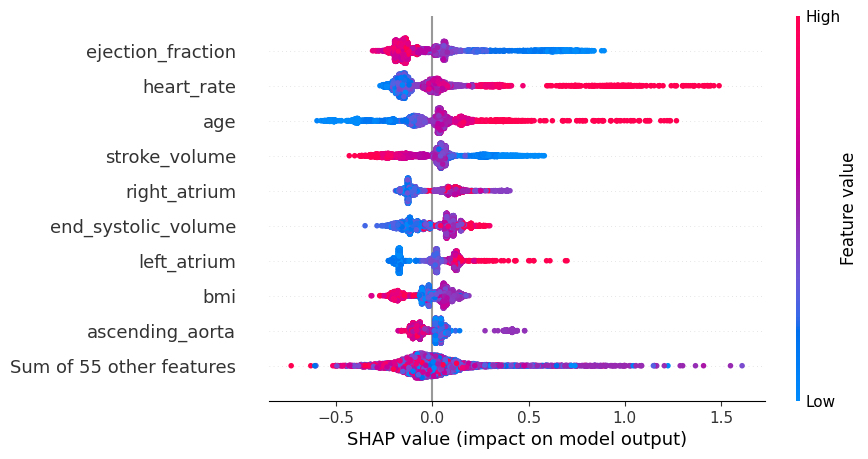

In [318]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_train_cut.to_pandas())
shap.plots.beeswarm(
    shap_values,
    plot_size=(8, 5),
)
plt.show()

In [263]:
# Get feature importances from CatBoost model
importances = model.get_feature_importance()
feature_names = X_train_cut.columns

# Combine with SHAP mean absolute values
shap_importance = np.abs(shap_values.values).mean(axis=0)

# Create DataFrame for both importances
feature_df = pd.DataFrame(
    {
        "feature": feature_names,
        "catboost_importance": importances,
        "shap_importance": shap_importance,
    }
)

# Sort by CatBoost importance and display top 20
top_features = feature_df.sort_values("catboost_importance", ascending=False).head(20)
print(top_features)

                            feature  catboost_importance  shap_importance
60                       heart_rate            11.577042         0.169495
62                ejection_fraction            10.851363         0.178352
59                              age            10.014319         0.146277
58  aorta_diameter_valsalva_sinuses             7.298117         0.051127
61                  ascending_aorta             7.296380         0.067877
56                    stroke_volume             7.147437         0.133063
52                      left_atrium             7.044315         0.109474
55              end_systolic_volume             6.868563         0.111858
51                     right_atrium             5.586231         0.112995
63                              bmi             5.115157         0.082905
53                  right_ventricle             4.169337         0.035577
57               ventricular_septal             2.971810         0.044333
54             end_diastolic_volume   

/var/folders/yt/5rqq39t16xs0vjb7z99vs0cw0000gn/T/ipykernel_97840/2708459409.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


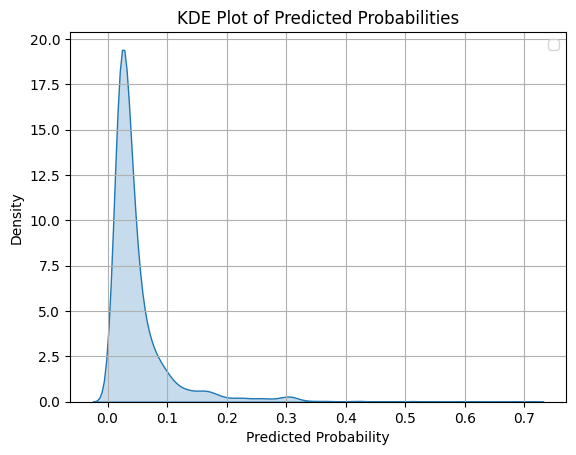

In [272]:
sns.kdeplot(
    model.predict_proba(X_train_cut.to_pandas())[:, 1],
    fill=True,
)
# sns.kdeplot(model.predict_proba(X_train_cut.to_pandas())[:, 1], fill=True)
plt.legend()
plt.xlabel("Predicted Probability")
plt.ylabel("Density")
plt.title("KDE Plot of Predicted Probabilities")
plt.grid()
plt.show()

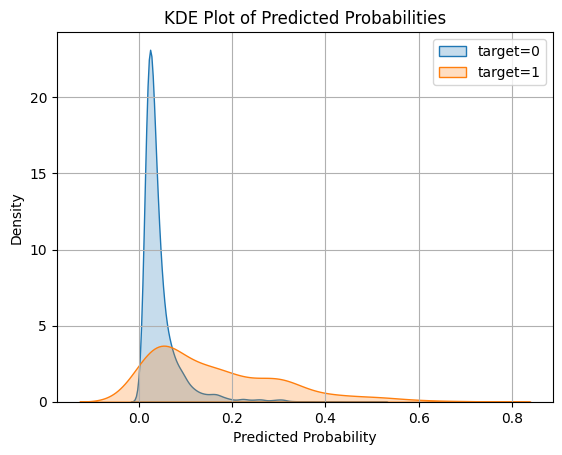

In [271]:
sns.kdeplot(
    model.predict_proba(X_train_cut.to_pandas()[(y_train_cut == 0).to_list()])[:, 1],
    fill=True,
    label="target=0",
)
sns.kdeplot(
    model.predict_proba(X_train_cut.to_pandas()[(y_train_cut == 1).to_list()])[:, 1],
    fill=True,
    label="target=1",
)
# sns.kdeplot(model.predict_proba(X_train_cut.to_pandas())[:, 1], fill=True)
plt.legend()
plt.xlabel("Predicted Probability")
plt.ylabel("Density")
plt.title("KDE Plot of Predicted Probabilities")
plt.grid()
plt.show()

gastritis_duodenitis,count
i64,u32
0,4512
1,147


other_anemias,count
i64,u32
0,4562
1,97


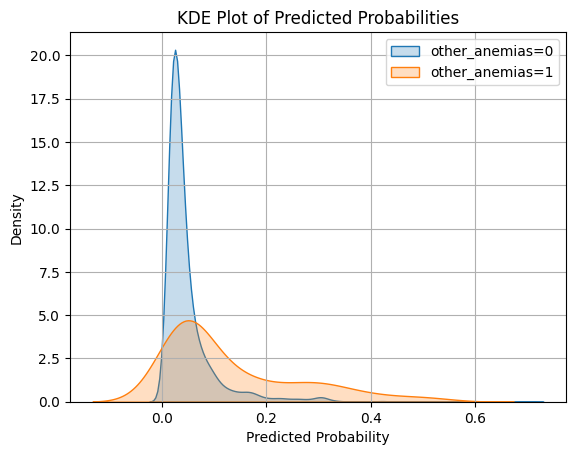

chronic_kidney_disease,count
i64,u32
1,201
0,4458


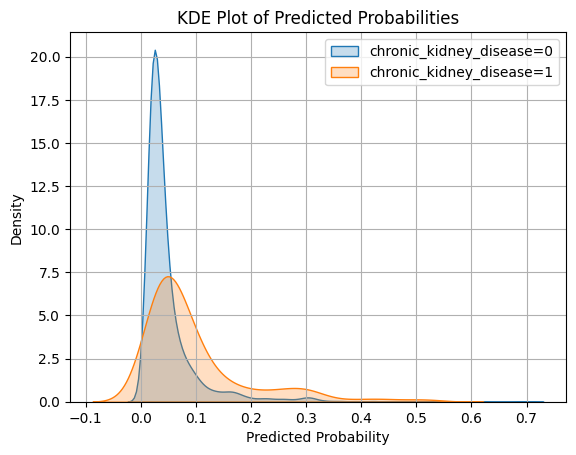

varicose_veins,count
i64,u32
0,4532
1,127


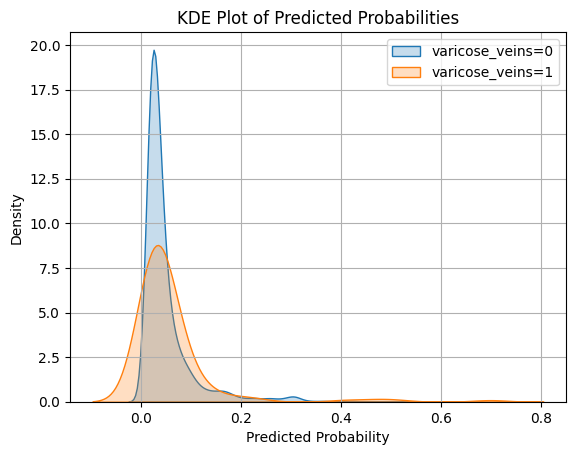

killip_class,count
i64,u32
3,39
2,35
1,4506
4,79


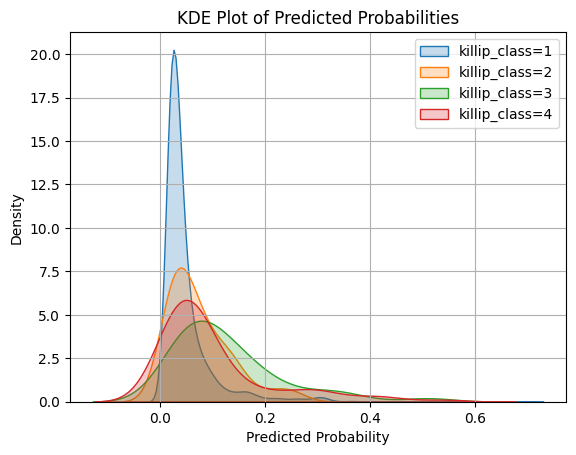

type2_diabetes,count
i64,u32
0,3571
1,1088


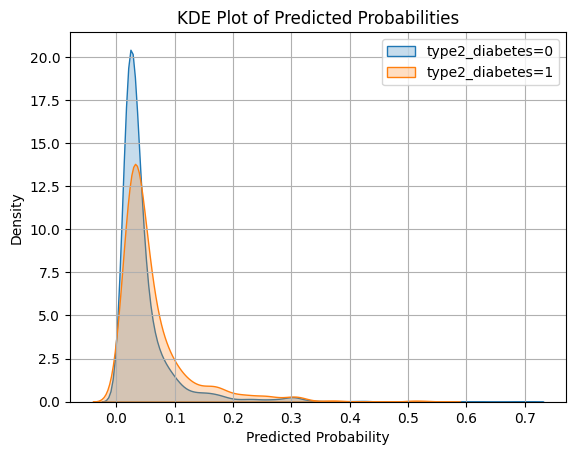

gender,count
i64,u32
1,3444
0,1215


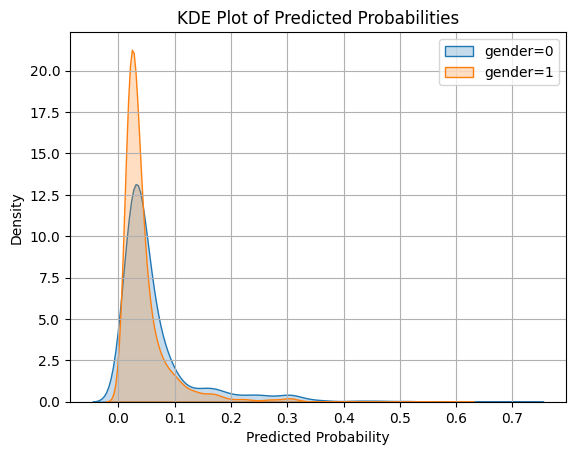

gastritis_duodenitis,count
i64,u32
0,4512
1,147


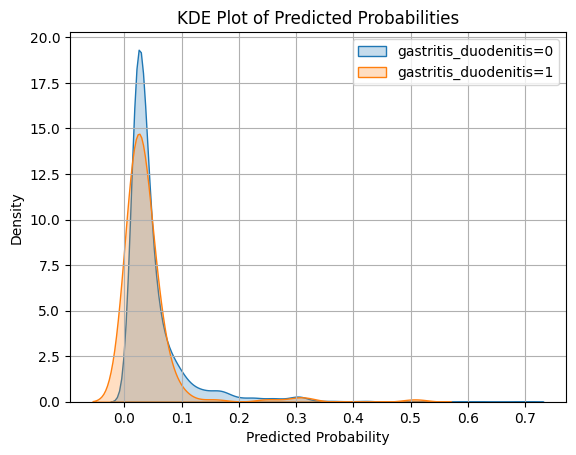

<Figure size 640x480 with 0 Axes>

In [281]:
binary_feature = "gender"
for binary_feature in set(top_features.feature) & set(icd_feature_map.values()):
    display(X_train_cut[binary_feature].value_counts())
    for i in X_train_cut[binary_feature].unique().sort().to_list():
        sns.kdeplot(
            model.predict_proba(X_train_cut.filter(c(binary_feature) == i).to_pandas())[
                :, 1
            ],
            fill=True,
            label=f"{binary_feature}={i}",
        )
    # sns.kdeplot(model.predict_proba(X_train_cut.to_pandas())[:, 1], fill=True)
    plt.legend()
    plt.xlabel("Predicted Probability")
    plt.ylabel("Density")
    plt.title("KDE Plot of Predicted Probabilities")
    plt.grid()
    plt.show()
    plt.tight_layout()

In [ ]:
# Evaluate the model
y_pred_proba_rf = model.predict_proba(X_test)[:, 1]
display(classification_metrics(y_test, y_pred_proba_rf))

## end